# Notebook Objectives
- This notebook is a part of my data science pipeline project which I'll be using this notebook to clean and explore the data scraped from jobsdb.
- The data after the processing step will be further used in my salary prediction model. 
- The features used in the salary prediction model will include job function, expereince year, and average salary.

#### Remark: This notebook can be quite biased due to multiple reasons such as
1. The data is scraped from a short time interval
2. Job post that explicitly show their salary in the job description may use it for attraction purposes. So these numbers may be higher than other job postings.
3. The data is based on only 1 website "jobsdb" other sources such as linkedin are not included.

## Importing Libraries & Load files

In [321]:
import glob
import pandas as pd
import numpy as np
import re

import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statistics import mode

from wordcloud import WordCloud, STOPWORDS

In [322]:
job_files = glob.glob('./*.csv')
jobs_df = pd.concat([pd.read_csv(file) for file in job_files],ignore_index = True)

##    Exploring data & duplicates

### Usually in job posting websites there're repost (duplicates) so we might as well remove them from our analysis 

In [323]:
print('Before drop duplicates',jobs_df.shape)
jobs_df.drop_duplicates(subset ="job_description", inplace = True) 
print('After drop duplicates',jobs_df.shape)

Before drop duplicates (19995, 9)
After drop duplicates (7491, 9)


In [324]:
jobs_df.head()

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description
0,HR Payroll Administrative(Junior Level),"[('admin-hr', 'administration-operation-clerical-support'), ('admin-hr', 'others'), ('admin-hr', 'compensation-benefits')]",Entry Level,1 year experience,Salary provided,"Full Time, Permanent",[],[],"Key Responsibilities include:To carry out all administrative processing in payroll taskFiling of HR and Payroll InformationData input, maintaining the accuracy of the HR system, Production and checking of data for payroll, performance and statutory reporting, and on requestProduce / create reports - routine or ad hoc on requestRespond effectively to calls/emails/ deal with post - incoming and outgoingParticipate in team activities (team meetings, training etc)Work within the relevant policies/ procedures / frameworksSkills required:Experience with HR or Administration at least 1 year.Preferably working towards a qualification in HRWork well as part of teamAttention to detailPositive attitudeProblem solvingAbility to manage and prioritise own workloadComputer Literate MS Office to include Word and ExcelExcellent time management"
1,Customer Service & Administrative Officer (English Skills) - รับนักศึกษาจบใหม่/Toeic 550 คะแนน,"[('admin-hr', 'administration-operation-clerical-support'), ('sales-cs-business-devpt', 'customer-service'), ('professional-services', 'translation')]",Entry Level,NaN,Salary provided,"Full Time, Permanent",['Job DescriptionGiving information to clients (responding to enquiries) over the telephone about SGS services and forwarding all necessary.Carring out follow up on all enquiries to generate as many proposals as possible for training and certification activities.Carry out follow-up on all Public Training courses to ensure such courses are filled.Recording all client details and required follow-up and resultsof follow-up on the Certnet database.Coordinating clients to Sales Executive as per defined segment and marketing campaign.Effectively co-ordinate client needs and other information with all other members of the Sales team and other divisions with in SGS.Punctuality disciplined and focused in carrying out duties.Support to manage project and support Senior Sales as assignment.'],"['s:Bachelor’s degree in relevant discipline.0-2 years experience in administration.Good command of english,written/ spoken.Having skill in Microsoft Office (Word and Excel) and including report writing.Good personality/ Having service mind.Able to work under pressure.Interested candidate, please submit a full detail resume and must including current salary and expected salary with a recent photograph to the e-mail addressSGS (Thailand) Limited02-678-1813 ext. 1117 ']","Job DescriptionGiving information to clients (responding to enquiries) over the telephone about SGS services and forwarding all necessary.Carring out follow up on all enquiries to generate as many proposals as possible for training and certification activities.Carry out follow-up on all Public Training courses to ensure such courses are filled.Recording all client details and required follow-up and resultsof follow-up on the Certnet database.Coordinating clients to Sales Executive as per defined segment and marketing campaign.Effectively co-ordinate client needs and other information with all other members of the Sales team and other divisions with in SGS.Punctuality disciplined and focused in carrying out duties.Support to manage project and support Senior Sales as assignment.Qualifications:Bachelor’s degree in relevant discipline.0-2 years experience in administration.Good command of english,written/ spoken.Having skill in Microsoft Office (Word and Excel) and including report writing.Good personality/ Having service mind.Able to work under pressure.Interested candidate, please submit a full detail resume and must including current salary and expected salary with a recent photograph to th

In [325]:
jobs_df.describe()

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description
count,7111,7491,6799,5310,7490,7490,7491,7491,7490
unique,6633,2897,15,32,137,69,4070,4279,7490
top,Accounting Manager,"[('information-technology', 'programming-software-development')]",Entry Level,5 years experience,Salary provided,"Full Time, Permanent",[],[],"ความรับผิดชอบหลัก:พัฒนา, ออกแบบ, และดำเนินการจัดทำ Guidelines สำหรับการพัฒนาข้อกำหนดของโปรแกรมให้มีประสิทธิภาพและเสร็จสิ้นภายในระยะเวลาที่กำหนดรายละเอียดงาน:วิเคราะห์, ออกแบบ, บำรุงรักษา, สนับสนุน และพัฒนาโปรแกรมวางแผนและดำเนินการพัฒนาโปรแกรมออกแบบระบบและฐานข้อมูลเพื่อใช้ในการพัฒนาโปรแกรมควบคุมตรวจสอบและทดสอบการพัฒนาโปรแกรมความรู้หรือประสบการณ์ในด้านต่อไปนี้:มีความรู้ในการวิเคราะห์และออกแบบกระบวนการทางธุรกิจจะพิจารณาเป็นพิเศษมีความรู้เกี่ยวกับ VB, MsSQL, MySQL, Net, Oracal, Microsoft Dynamics AX 365 หรือ Delphiภาษาโปรแกรม: มีความรู้เกี่ยวกับเทคโนโลยี Microsoft Dynamics (X ++, Visual Studio, SQL ServerReport Service: SSRS, AOT) จะได้รับการพิจารณาเป็นพิเศษคุณสมบัติผู้สมัครชาย / หญิง อายุไม่เกิน 45 ปี สัญชาติไทยเท่านั้นวุฒิปริญญาตรีขึ้นไป สาขาวิทยาการคอมพิวเตอร์, วิศวกรรมคอมพิวเตอร์, เทคโนโลยีสารสนเทศ หรือสาขาอื่นที่เกี่ยวข้องมีประสบการณ์การพัฒนาโปรแกรมอย่างน้อย 3 ปีขึ้นไปสามารถวิเคราะห์และออกแบบระบบได้มีบุคลิกภาพดีและมีทักษะในการสื่อสารที่ดีมีทักษะการแก้ปัญหาเฉพาะหน้าได้ดีสามารถใช้ภาษาอังกฤษในการอ่านและเขียนปานกลางความสามารถในการทำงานในสภาพแวดล้อมที่มีแรงดันสูงหากมีประสบการณ์การพัฒนาระบบ ERP ด้าน Garment และใช้ Delphi Develop จะได้รับการพิจารณาเป็นพิเศษIf interested, please send a resume inEnglish Version with Photo and yourExpected Salarythrough ""Apply Now"". Any question, please feel free to contact HR Department.LibInter GroupLiberty Garment / Trax Intertraade137/63 Soi Latphrao 41, Latphrao Road, Chantharakasem, Chatuchak, Bangkok 10900, ThailandTel. +66 02 541-9309 to16 Ext.1001, 1322, 1407Website: http://www.libgroup.com/"
freq,14,112,2362,1247,3903,4114,3192,3192,1


In [326]:
# jobs_df.to_csv('all_jobs.csv',index = False)
# jobs_df = pd.read_csv('all_jobs.csv')

### Seems like there're some missing values in our dataset let's explore them.

In [327]:
# identify na values
jobs_df.isna().mean()

job_title               0.050728
job_categories          0.000000
career_level            0.092378
experience_year         0.291149
salary                  0.000133
employment_type         0.000133
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000133
dtype: float64

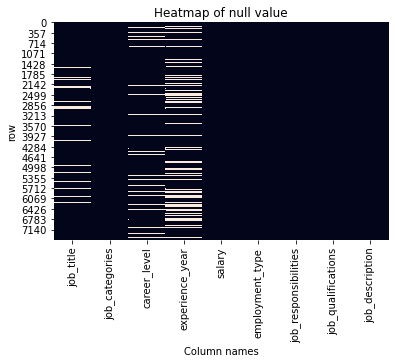

In [328]:
# Heatmap of na value
ax = sns.heatmap(jobs_df.isnull(), cbar=False)
ax.set(xlabel='Column names', ylabel='row',title = 'Heatmap of null value')
plt.show()

### Strip string columns

In [329]:
strip_list = ['job_title','career_level','experience_year','salary','employment_type','job_description']
jobs_df[strip_list] = jobs_df[strip_list].apply(lambda x: x.str.strip())

## Job function extraction

### It can be seen that each job can belong into multiple categories.
1. For our analysis since we do not have much data I've decided to keep the top most function of each job e.g. admin-hr
2. So we take the first value inside every tuple and find their mode to identify the job top function
3. If mode cannot be decided, we return the first job function found (assuming that the job poster will highlight the most relevent job function first. 

#### Note that job_categories is a string so we have to use regular expression to extract the job functions

In [330]:
jobs_df['job_categories'].head(1)

0    [('admin-hr', 'administration-operation-clerical-support'), ('admin-hr', 'others'), ('admin-hr', 'compensation-benefits')]
Name: job_categories, dtype: object

In [331]:
def get_top_job_function(job_category):
    job_category = job_category.replace('"','').replace("'",'')
    return re.findall("\((.*?),",job_category)

In [332]:
jobs_df['job_top_function'] = jobs_df['job_categories'].apply(lambda x : get_top_job_function(x))
jobs_df['job_top_function'] = jobs_df['job_top_function']
jobs_df['job_top_function'].head(5)

0                                [admin-hr, admin-hr, admin-hr]
1    [admin-hr, sales-cs-business-devpt, professional-services]
2                   [admin-hr, admin-hr, professional-services]
3                              [accounting, admin-hr, admin-hr]
4     [engineering, sciences-lab-researchdevelopment, admin-hr]
Name: job_top_function, dtype: object

### get_top_job function example input and output
#### e.g. input = ['admin-hr','admin-hr']  output = 'admin-hr'
#### e.g. input = ['admin-hr','accounting','design'] output = 'admin-hr' (Because admin-hr is found first)

In [333]:
def get_top_job(job_functions):
    if len(job_functions)==0:   # Check if job_functions is available
        return []
    try:                        # Try to return mode of job_functions
        return mode(job_functions)
    except:         
        return job_functions[0] # return the first found job function

In [334]:
jobs_df['job_top_function'] = jobs_df['job_top_function'].apply(lambda x : get_top_job(x))
jobs_df['job_top_function'] = jobs_df['job_top_function'].astype(str)

In [335]:
plot_job_top_function = jobs_df.groupby('job_top_function').size().sort_values(ascending = False).reset_index().rename(columns = {0:'count'})

#### Explore popular job function in jobsdb

In [336]:
fig = px.bar(plot_job_top_function, x="job_top_function", y="count")
fig.show()

## Salary & Experience year extraction
### Note that salary & experience year scraped from the website is in a string format so we have to extract them using regular expression

In [337]:
jobs_df['salary'].value_counts().head(10)

Salary provided                           4076
Salary negotiable                         2332
Base salary + high commission               92
THB70,000 - 120,000 /month                  53
THB45,000 - 70,000 /month                   38
THB35,000 - 55,000 /month                   38
THB90,000 - 120,000 /month                  32
THB35,000 - 45,000 /month                   30
THB30,000 - 45,000 /month                   30
THB55,000 - 70,000 /month (negotiable)      29
Name: salary, dtype: int64

In [338]:
jobs_df['experience_year'].value_counts().head(10)

5 years experience     1247
3 years experience     1187
2 years experience      811
1 year experience       601
10 years experience     362
7 years experience      249
8 years experience      221
4 years experience      215
6 years experience       66
15 years experience      60
Name: experience_year, dtype: int64

In [339]:
#Extract Experience year
jobs_df['experience_year'] = jobs_df['experience_year'].str.extract('([0-9]+)')

In [340]:
#Remove , from Salary
jobs_df['salary'] = jobs_df['salary'].str.replace(',','')

#### There's also a hourly rate! so we should convert them to a monthly rate

In [341]:
#include high commission, THB60 - 99 /hour (negotiable)
jobs_df[jobs_df['salary'].str.contains('hour').fillna(False)]

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description,job_top_function
2198,SPORT ADVISOR (PART-TIME) @ DecathlonBangna (flagship store Thailand),"[('sales-cs-business-devpt', 'retail-sales'), ('others', 'student-fresh-graduate-no-experience'), ('management', 'management-trainee')]",Entry Level,NaN,THB60 - 99 /hour (negotiable),"Contract, Internship, Part Time, Permanent",[],[],"POSITION: SPORT ADVISOROur CompanyPresent in 49 countries, brings together two different activities: producing international sports products and sport retail activity. These two areas of expertise, along with all our own brands, are united behind a common purpose: To make sports accessible to the many!DECATHLON, the original chain created in 1976 in France, and the other local and online retail formats, sell our own Passion brand products, made with materials provided by our own production team. Thanks to our 100 000 employees, Decathlon controls the whole development chain: from Research & Development to the sales floor, including design, production and logistics. We can proudly say that we opened 10 stores already during the past 4 years and we plan to open many more stores! So we need many more sportspeople.OUR COMMITMENTS:You will earn 65 THB/hour in your first year, 70 THB/hour in your second year and 75 THB/hour in your third year. You will get provident fund to build up your pensionYou will get a medical insurance (Generali)You have the option to become a shareholder of our companyYou will get a bonus once a year depending on the performance of Decathlon ThailandYou have the opportunity to start your career full-time in DecathlonYou will get trained & coached to become an autonomous teammateYou will work in a open-minded team and in a fun and social work environmentYOUR COMMITMENT:You work on weekends and on public holidays & you work minimum 8 days a month (8 hours per day)WHO ARE YOU:You can communicate in EnglishYou practice a sport regularlyYou have smile on your face and you are customer orientedYou love to take decisions by yourself, you like to take initiativesYou are responsible as you will get a lot of freedom at DecathlonYou are a vital personYou are flexibleJOB RESPONSIBILITIES:Advice customers when they buy their sport productsCashierOrganize the sales areaHandle product deliveries efficientlyManage a certain group of products (layout, stock management, merchandising & analyze financial performance) as a preparation for when you start a full-time career in Decathlon. WE ARE LOOKING FOR PASSIONATE SPORT LOVERS.IF YOU LOVE ANY OF THESE SPORTS, LET'S JOIN US!!!American footballAqua gymArcheryAthletic runningBackpackingBadmintonBaseballBasketballBoatingBody boardingBoxingCampingCity cyclingClimbingCricketCross-trainingDancingDartsField hockeyFishingFitness cardioFlying discFootballFree divingFutsalGolfGymnasticsHandballHorse ridingIce hockeyInline skatingIce skatingJudoKarateKayakingKids cyclingKite sportsMountain bikingMuay ThaiPetanquePilateRoad cyclingRugbyScooteringScuba divingSkateboardingSkiingSnowboardingSnorkelingSquashStand up paddlingSurfingSwimmingTable tennisTaekwandoTakrawTennisTouring cyclingTrail runningTrekkingTriathlonVolleyballWakeboardingWalkingWater poloWildlife observationYoga",sales-cs-business-devpt


In [342]:
#Change to monthly rate by hourly rate x 8 x 20
jobs_df['salary'] = jobs_df['salary'].replace('THB60 - 99 /hour (negotiable)','THB9600 - 15840 /month (negotiable)')

In [343]:
#Extract min and max salary & high commission & negotiable
jobs_df[['min_salary','max_salary']] = jobs_df['salary'].str.extract('THB([0-9]*) - ([0-9]*)')

### Let's see how well our extraction method work

In [344]:
jobs_df[~jobs_df['salary'].isin(['Salary provided','Salary negotiable'])][['salary','min_salary','max_salary']]

,salary,min_salary,max_salary
16,THB25000 - 35000 /month,25000,35000
17,THB20000 - 30000 /month (negotiable),20000,30000
25,THB16000 - 20000 /month,16000,20000
32,THB45000 - 70000 /month,45000,70000
38,THB90000 - 120000 /month (negotiable),90000,120000
...,...,...,...
7453,THB25000 - 45000 /month (negotiable),25000,45000
7454,THB25000 - 45000 /month,25000,45000
7462,THB45000 - 55000 /month,45000,55000
7467,Above THB120000 /month,NaN,NaN


### We did extract salary in the form of xxxxx-xxxxx / month but we still have to extract "Up to & Above" cases

#### Extract Salary for "Above" / "Up to" cases

In [345]:
## fill min & max salary for 'Above/Up to case'

jobs_df['min_salary'] = jobs_df['min_salary'].fillna(jobs_df['salary'].str.extract('Above THB([0-9]*)')[0])
jobs_df['max_salary'] = jobs_df['max_salary'].fillna(jobs_df['salary'].str.extract('Up to THB([0-9]*)')[0])


#### Inspect our salary extraction

In [346]:
jobs_df[~jobs_df['salary'].isin(['Salary provided','Salary negotiable'])][['salary','min_salary','max_salary']]

,salary,min_salary,max_salary
16,THB25000 - 35000 /month,25000,35000
17,THB20000 - 30000 /month (negotiable),20000,30000
25,THB16000 - 20000 /month,16000,20000
32,THB45000 - 70000 /month,45000,70000
38,THB90000 - 120000 /month (negotiable),90000,120000
...,...,...,...
7453,THB25000 - 45000 /month (negotiable),25000,45000
7454,THB25000 - 45000 /month,25000,45000
7462,THB45000 - 55000 /month,45000,55000
7467,Above THB120000 /month,120000,NaN


In [347]:
jobs_df.isna().mean()

job_title               0.050728
job_categories          0.000000
career_level            0.092378
experience_year         0.291149
salary                  0.000133
employment_type         0.000133
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000133
job_top_function        0.000000
min_salary              0.867975
max_salary              0.874516
dtype: float64

#### Based on our exploration it seems that most job posting doesnt explicitly tells the salary range in the Job summary. However, the salary can be present in the job title or job description which we will try to extract. (Later in this notebook)

## Some experience year are still missing so we fill experience year with groupby career level mean

In [348]:
jobs_df['experience_year'] = jobs_df['experience_year'].astype(float)

In [349]:
jobs_df.columns

Index(['job_title', 'job_categories', 'career_level', 'experience_year',
       'salary', 'employment_type', 'job_responsibilities',
       'job_qualifications', 'job_description', 'job_top_function',
       'min_salary', 'max_salary'],
      dtype='object')

### However, there're some unexpected categories in career level column e.g. Full Time / Full Time, Internship which is actually  employment type. So we replace them with nan

In [350]:
jobs_df[jobs_df['career_level'].isin(['Contract','Full Time','Full Time, Internship',
                                                               'Full Time, Permanent','Internship','Part Time',
                                                               'Permanent'])].head(2)

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description,job_top_function,min_salary,max_salary
832,NaN,"[('information-technology', 'application-specialist-software'), ('information-technology', 'support'), ('information-technology', 'programming-software-development')]",Full Time,NaN,Salary provided,Full Time,"[' Salary up 90,000 THB + benefitsLocation: Bangkok, BTSOur client focuses within the Food and Beverage industry, providing high-quality IT solutions covering web application and software to enhance food lovers experience. After succeeding around Southeast Asia, they’re now entering the Thai market and are in search for a .Net backend engineer to add to their new team in Bangkok.You’ll be coordinating with their Head office in developing and supporting systems for their clients. This is a great opportunity for those who would like to work in an international company which has a very promising future.Responsibilities:· Develop new features and products through C# .NET· Monitor error and fix bug· Evaluate requirements· CRM Enhancement· Coordinate with all users· Troubleshoot where necessary']",['s:· Bachelor’s Degree in Computer Science or related field· At least 3 years’ experience in C# .NET Development· Proven experience in POS· Kiosk experience is a big plus· Good Command of English is a must· Good Communication skillsThis is a great opportunity if you are looking to challenge yourself and grow alongside a successful business in its industry. For more information call Ying at 02-038-5878. '],"Salary up 90,000 THB + benefitsLocation: Bangkok, BTSOur client focuses within the Food and Beverage industry, providing high-quality IT solutions covering web application and software to enhance food lovers experience. After succeeding around Southeast Asia, they’re now entering the Thai market and are in search for a .Net backend engineer to add to their new team in Bangkok.You’ll be coordinating with their Head office in developing and supporting systems for their clients. This is a great opportunity for those who would like to work in an international company which has a very promising future.Responsibilities:· Develop new features and products through C# .NET· Monitor error and fix bug· Evaluate requirements· CRM Enhancement· Coordinate with all users· Troubleshoot where necessaryQualifications:· Bachelor’s Degree in Computer Science or related field· At least 3 years’ experience in C# .NET Development· Proven experience in POS· Kiosk experience is a big plus· Good Command of English is a must· Good Communication skillsThis is a great opportunity if you are looking to challenge yourself and grow alongside a successful business in its industry. For more information call Ying at 02-038-5878.",information-technology,NaN,NaN
1183,NaN,"[('information-technology', 'it-project-management-team-lead'), ('information-technology', 'testing-qa'), ('information-technology', 'it-consulting')]",Full Time,NaN,Salary provided,Full Time,"[' Location: BTS/MRTSalary: up to 50,000 THB + BenefitsCompany:Cathcart Associates has a great opportunity for a Technical Business Analyst to join a Software and IT Service Company who provide end to end solutions. Our client covers strategic planning, customer experience design, implementation and managed services.Responsibilities:You will work with a team to develop a technical sales strategy, configure and demonstrate the solutions that address these requirements and provide business value. You must understand customer solution requirements from end to end, recommend the better solution to customers and also be able to work as part of a team to solve business and technical problems.']","['sBachelor’s degree in Computer Science, Computer Engineering or MIS or MBA related fieldsAt least2-5 years’ experience in Business Analysis or System Analyst Good communication and effective team workAdaptive and Problem-Solving issueHave techn

In [351]:
# Replace unexpected career level with nan
jobs_df.loc[jobs_df['career_level'].isin(['Contract','Full Time','Full Time, Internship','Full Time, Permanent','Internship','Part Time','Permanent'])] = np.nan

In [352]:
jobs_df['career_level'].value_counts()

Entry Level     2541
Middle level    2270
Senior level    1608
Top level        180
Middle            79
Senior            65
Top                5
Name: career_level, dtype: int64

In [353]:
jobs_df.groupby('career_level')['experience_year'].mean()

career_level
Entry Level      2.348288
Middle           3.888889
Middle level     4.121860
Senior           6.550000
Senior level     6.479760
Top             12.000000
Top level        9.653595
Name: experience_year, dtype: float64

### Clean career Level category into Entry/Middle/Senior/Top

In [354]:
jobs_df['career_level'] = jobs_df['career_level'].replace('Middle level','Middle')
jobs_df['career_level'] = jobs_df['career_level'].replace('Senior level','Senior')
jobs_df['career_level'] = jobs_df['career_level'].replace('Top level','Top')

#clean career_level that is actually employment type
# jobs_df['career_level'] = jobs_df[~jobs_df['career_level'].isin(['Contract','Full Time','Full Time, Internship',
#                                                                'Full Time, Permanent','Internship','Part Time',
#                                                                'Permanent'])]['career_level']

In [355]:
jobs_df.groupby('career_level')['experience_year'].mean()

career_level
Entry Level    2.348288
Middle         4.113227
Senior         6.482783
Top            9.713376
Name: experience_year, dtype: float64

In [356]:
jobs_df["experience_year"] =jobs_df["experience_year"].fillna(jobs_df.groupby('career_level')['experience_year'].transform('mean'))
jobs_df['experience_year'] = jobs_df['experience_year'].astype(float)

## Explore popular jobs in jobsdb for each career level

In [357]:
# See popular jobs on jobsdb for each career level

from plotly.subplots import make_subplots
entry_level = jobs_df[jobs_df['career_level'] == 'Entry Level']['job_top_function'].value_counts(normalize=True)
middle_level = jobs_df[jobs_df['career_level'] == 'Middle']['job_top_function'].value_counts(normalize=True)
senior_level = jobs_df[jobs_df['career_level'] == 'Senior']['job_top_function'].value_counts(normalize=True)
top_level = jobs_df[jobs_df['career_level'] == 'Top']['job_top_function'].value_counts(normalize=True)

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'},{'type':'domain'}]])
fig.add_trace(go.Pie(labels=entry_level.index, values=entry_level.values, name="Entry Level"),1, 1)
fig.add_trace(go.Pie(labels=middle_level.index, values=middle_level.values, name="Middle Level"),1, 2)
fig.add_trace(go.Pie(labels=senior_level.index, values=senior_level.values, name="Senior Level"),2, 1)
fig.add_trace(go.Pie(labels=top_level.index, values=top_level.values, name="Top Level"),2, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_traces(textposition='inside')
fig.update_layout(width=1000, height=700,
    title_text="Pie chart of job function for each career level",
    
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Entry Level', x=0.150, y=0.5, font_size=16, showarrow=False),
                 dict(text='Middle Level', x=0.860, y=0.5, font_size=16, showarrow=False),
                dict(text='Senior Level', x=0.150, y=-0.1, font_size=16, showarrow=False),
                dict(text='Top Level', x=0.830, y=-0.1, font_size=16, showarrow=False)])
fig.show()  

### IT/Sales/Engineering related job seems to dominate in Entry/Middle Level. However, for Senior and top level it seems that there're more varieties of jobs.

In [358]:
# fig = go.Figure(go.Histogram2d(
#         x=jobs_df.career_level,
#         y=jobs_df.job_top_function,
#         hovertemplate='Career Level : %{x}<br>Types: %{y}<br>Frequency: %{z}<extra></extra>',
#         colorbar=dict(title='Frequency'),
#         colorscale = 'Viridis'
#     ))
# fig.update_layout(
#     title_text='Density plot of job function & career level', 
#     xaxis_title_text='Career Level', 
#     yaxis_title_text='Job Function')
# fig.show()

## Word Cloud for each career level

In [359]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### Let's explore job description word cloud for all 4 career levels


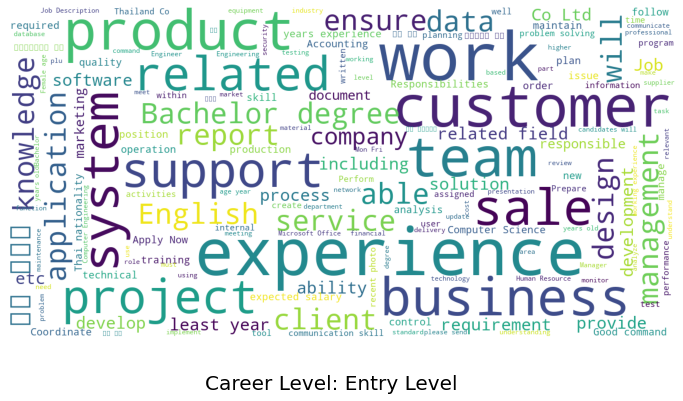

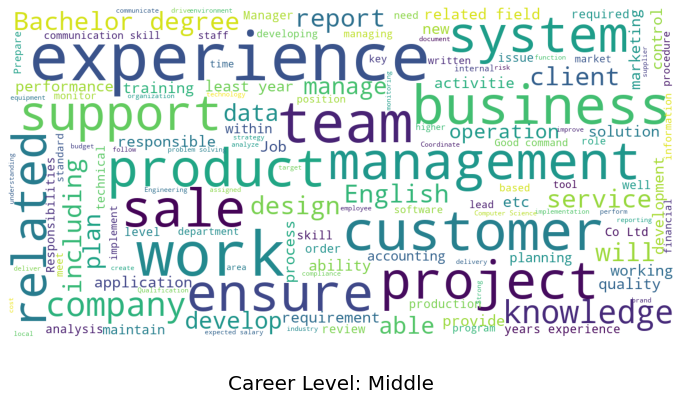

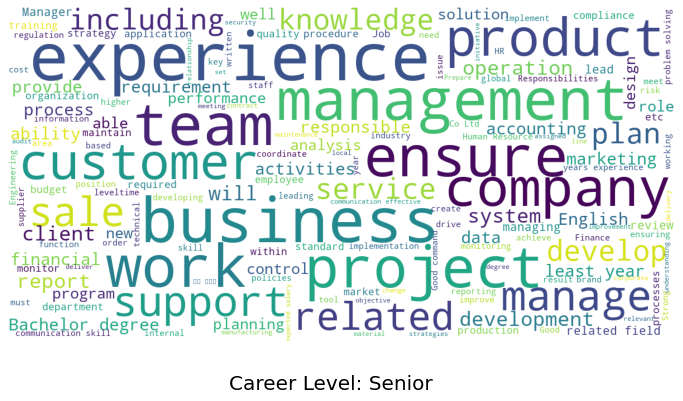

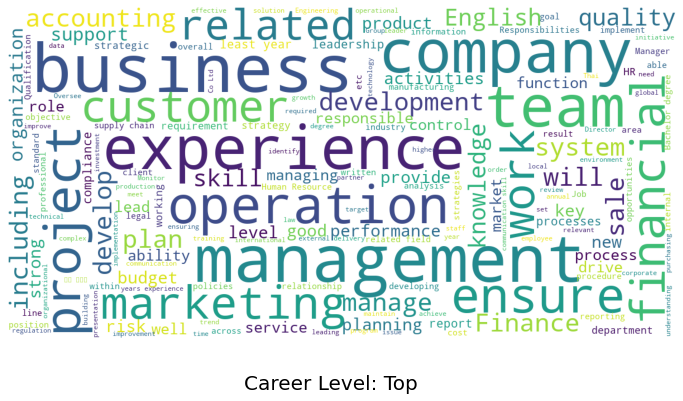

""


In [360]:
stopwords = set(STOPWORDS)
jobs_df.groupby('career_level').apply(
    lambda x: show_wordcloud(x.job_description.tolist(), title=f"Career Level: {x.name}"))

### It can be seen that as career level grows candidates are expected to do more management work and be skilled in business.

## As mentioned above, salary can be mentioned inside the job title or job description instead of the job summary.Thus, we could try extracting salary from job title & job description  

In [361]:
jobs_df['job_description'] = jobs_df['job_description'].str.lower()
jobs_df['job_description'] = jobs_df['job_description'].str.replace(',','')

In [362]:
no_salary = jobs_df[jobs_df['salary'].isin(['Salary provided','Salary negotiable','Base salary + high commission'])].reset_index().drop(columns = ['index'])

In [363]:
no_salary.isna().mean()

job_title               0.043519
job_categories          0.000000
career_level            0.093852
experience_year         0.079758
salary                  0.000000
employment_type         0.000000
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000000
job_top_function        0.000000
min_salary              1.000000
max_salary              1.000000
dtype: float64

In [364]:
print('Rows with no salary in the job summary:',no_salary.shape[0])

Rows with no salary in the job summary: 6457


### For job description salary extraction, it is quite difficult to extract salary using simple regular expression due to salary may be written in many different format e.g. 40-70k, 40k-70k, 40000-70000 thb, and more..
### My idea of extracting salary from long text are as follows
1. First, split the job description into a list of words
2. Second, check for each word if the number contains a number
3. Third, if the word contains a number or a number followed by the letter "k" it is a salary candidate.
4. Fourth, if the word is found at the end of the job description (after 80% of the text) it is not considered a salary (because it is usually a phone number)
5. Fifth, check if the salary contains "k" in the salary if true, we append it to a list for that job description (it will be used later to multiply by 1000)
6. Lastly, we exclude not possible salary out which are salary less than 1000 or salary greater than 500000 and salary is not divisible by 1,000. if the exclusion is done we append it to a list for that job description

In [365]:
def convert_float(word):
    try:
        return float(word)
    except ValueError:
        return word

In [366]:
###ลองไล่ๆดูมีเคสอะไรบ้าง
pattern = re.compile(r'\W+')
salary_fill_list = []
for description in no_salary['job_description'].tolist():
#     print('----------------------------------------------------------------------------')
    if description != '':
        # print(description)
        word_list = pattern.split(description)
#         print(word_list)
        salary_fill = []
        for idx,word in enumerate(word_list):
            float_in_word = re.match('[0-9]+k?',word)
            if float_in_word != None:
                salary_candidate = convert_float(float_in_word[0])
    #             print(type(salary_candidate))
                if idx >= 0.8*len(word_list):
                    pass
    #                 print('Found late:',salary_candidate)
                else:
    #                 print('Found Early:',salary_candidate)
                    if type(salary_candidate) == str:
                        salary_fill.append(salary_candidate)
                    elif salary_candidate >= 10000 and salary_candidate <= 500000 and salary_candidate % 1000 ==0:
                        salary_fill.append(salary_candidate)        
        # print(salary_fill)
        salary_fill_list.append(salary_fill)

### The salary_fill_list is a list containing salary candidates for each row 

In [367]:
#Some example of salary_fill_list
salary_fill_list[5:20]

[[],
 [],
 [],
 [],
 [30000.0, 40000.0],
 [50000.0, 70000.0],
 ['120k'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['45k']]

In [368]:
fill_salary = no_salary.copy()

#### we finally extract the minimum and maximum salary by taking the first and second value from the salary_fill_list

In [369]:
fill_salary['salary_fill'] = salary_fill_list
fill_salary['min_salary'] = fill_salary['salary_fill'].apply(lambda x: x[0] if len(x)>=1 else np.nan)
fill_salary['max_salary'] = fill_salary['salary_fill'].apply(lambda x: x[1] if len(x)>=2 else np.nan)


#### if k is in the salary we multiply it by 1000

In [370]:
fill_salary = fill_salary.drop(columns = ['salary_fill'])
fill_salary['min_salary'] = fill_salary['min_salary'].apply(lambda x: float(x[:-1])*1000 if 'k' in str(x) else x)
fill_salary['max_salary'] = fill_salary['max_salary'].apply(lambda x: float(x[:-1])*1000 if 'k' in str(x) else x)

### Some job post does not write their salary in the job description but rather the job title. So we could extract from them too.
### Extracting from job title is a little simplier because the text is much more shorter and usually it is in similar format so using regex and check if the salary contains "k" we multiply it by 1000

In [371]:
fill_salary['job_title'] = fill_salary['job_title'].str.lower()
fill_salary[['min_salary_title','max_salary_title']] = fill_salary['job_title'].str.extract('([0-9]+k?)[ ]?(-|–)?[ ]?(([0-9]+)?[ ]?k?)')[[0,2]]

In [372]:
fill_salary['has_k'] = (fill_salary['min_salary_title'].str.contains('k') | fill_salary['max_salary_title'].str.contains('k')) #only run this once becauase already remove next line
fill_salary['min_salary_title'] = fill_salary['min_salary_title'].str.replace('k','')
fill_salary['max_salary_title'] = fill_salary['max_salary_title'].str.replace('k','')

fill_salary['max_salary_title'] = fill_salary['max_salary_title'].replace(r'\s+',np.nan,regex=True).replace('',np.nan)
fill_salary['max_salary_title'] = fill_salary['max_salary_title'].fillna(0)


In [373]:
fill_salary['min_salary_title'] = fill_salary.apply(lambda x: float(x['min_salary_title'])*1000 if x['has_k'] == True else x['min_salary_title'],axis = 1)
fill_salary['max_salary_title'] = fill_salary.apply(lambda x: float(x['max_salary_title'])*1000 if x['has_k'] == True else x['max_salary_title'],axis = 1)
fill_salary['max_salary_title'] = fill_salary['max_salary_title'].replace(0,np.nan)

fill_salary[fill_salary['has_k']== True][['min_salary_title','max_salary_title','has_k']].head(10)

,min_salary_title,max_salary_title,has_k
10,50000,70000,True
11,100000,120000,True
24,100000,NaN,True
25,50000,80000,True
33,60000,65000,True
35,40000,NaN,True
42,40000,NaN,True
48,80000,NaN,True
52,15000,20000,True
64,20000,28000,True


In [374]:
fill_salary['min_salary_title'] = fill_salary['min_salary_title'].astype(float)
fill_salary['max_salary_title'] = fill_salary['min_salary_title'].astype(float)

In [375]:
fill_salary = fill_salary.drop(columns = ['has_k'])

#### We then fillna the min_salary & max_salary found in job_description with our salary found in the title

In [376]:
fill_salary['min_salary'] = fill_salary['min_salary'].fillna(fill_salary['min_salary_title'])
fill_salary['max_salary'] = fill_salary['max_salary'].fillna(fill_salary['max_salary_title'])

In [377]:
pd.set_option('max_colwidth', 5000)
fill_salary[['job_title','min_salary','max_salary']].head(10)

,job_title,min_salary,max_salary
0,hr payroll administrative(junior level),NaN,NaN
1,customer service & administrative officer (english skills) - รับนักศึกษาจบใหม่/toeic 550 คะแนน,550.0,550.0
2,social auditor - hr / compensation & benefit / safety/ผู้ตรวจด้านงานค่าแรงค่าจ้าง และ ความปลอดภัย,NaN,NaN
3,senior administrative & secretary executive,NaN,NaN
4,hse auditor - ประสบการณ์ 5 ปี/ผู้ตรวจสอบสายงาน environmental health and safety - ประสบการณ์ 5 ปี,5.0,5.0
5,"auditor >> sedex-smeta, sa8000, wrap, c-tpat, ursa, sgp, tls8001, bsci and coc (code of conduct)/ผู้ตรวจสอบ sedex-smeta, sa8000, wrap, c-tpat, ursa, sgp, tls8001, bsci and coc (code of conduct)",8000.0,8000.0
6,"senior manager, fleet recruitment (suksawat 84)",84.0,84.0
7,"specialist, activities (employee relation)",NaN,NaN
8,compensation & benefits specialist,NaN,NaN
9,administrative officer,30000.0,40000.0


### Sometimes our regex does wrongly match (e.g. matches exprience year / required test scores etc.) so we will do a final filter using the same condition used in job description

In [378]:
fill_salary = fill_salary.dropna(how = 'all',subset = ['min_salary','max_salary'])

In [379]:
fill_salary['min_salary'] = fill_salary['min_salary'].astype(float)
fill_salary['max_salary'] = fill_salary['max_salary'].astype(float)

In [380]:
def filter_salary(sal):
    if sal == np.nan:
        return sal
    elif sal <= 10000 or sal >= 500000 or sal%1000 != 0:
        return np.nan
    else:
        return sal

In [381]:
fill_salary['min_salary'] = fill_salary['min_salary'].apply(lambda x: filter_salary(x) if pd.notnull(x) else x)
fill_salary['max_salary'] = fill_salary['max_salary'].apply(lambda x: filter_salary(x) if pd.notnull(x) else x)

In [382]:
fill_salary.shape

(1438, 14)

In [383]:
fill_salary[['job_title','min_salary','max_salary']].tail(10)

,job_title,min_salary,max_salary
6420,talent management specialist ( 12 months contract extendable),NaN,NaN
6423,"senior crm manager - up to 150,000 thb",NaN,NaN
6427,programmer (at 304 industrial park),35000.0,42000.0
6428,it infrastructure (at 304 industrial park),35000.0,42000.0
6430,technical product owner / bts/mrt line / max: 130k,130000.0,130000.0
6432,NaN,100000.0,NaN
6440,as400/rpg senior programmer (30k-45k) (sdg-53227)/โปรแกรมเมอร์อาวุโส as400 และ rpg,30000.0,45000.0
6441,"system engineer (unix, linux, oracle, db2)",NaN,NaN
6442,it security manager (90k-130k) (sdg-53176)/ผู้จัดการความปลอดภัยด้านไอที,90000.0,130000.0
6456,service desk/technical broadcasting 1 year contract /welcome new graduates,NaN,NaN


### Looks good, now let's see how many rows did we get.

In [384]:
fill_salary = fill_salary.dropna(how='all', subset=['min_salary','max_salary'])
fill_salary = fill_salary.drop(columns = ['min_salary_title','max_salary_title'])

In [385]:
print('Number of rows of no salary:' ,no_salary.shape[0])

Number of rows of no salary: 6457


In [386]:
print('Number of rows filled with salary from job title/job desccription:' ,fill_salary.shape[0])

Number of rows filled with salary from job title/job desccription: 1025


In [387]:
jobs_df = jobs_df.dropna(how='all', subset=['min_salary','max_salary'])

In [388]:
print('Original rows of job with no missing salary:',jobs_df.shape[0])

Original rows of job with no missing salary: 982


In [389]:
jobs_df = pd.concat([jobs_df,fill_salary],ignore_index = False)

In [390]:
print('New Jobs data with filled salary:',jobs_df.shape[0])

New Jobs data with filled salary: 2007


In [391]:
jobs_df.isna().mean()

job_title               0.032885
job_categories          0.000000
career_level            0.065272
experience_year         0.051320
salary                  0.000000
employment_type         0.000000
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000000
job_top_function        0.000000
min_salary              0.002491
max_salary              0.103139
dtype: float64

### Now we have around 2 times more data rows for model training and salary analysis which is pretty neat.

# ----------------------------------------

## Salary EDA

In [392]:
jobs_df[['min_salary', 'max_salary']] = jobs_df[['min_salary', 'max_salary']].apply(pd.to_numeric)
jobs_df['average_salary'] = jobs_df[['min_salary', 'max_salary']].mean(axis = 1)

In [393]:
jobs_df[['min_salary', 'max_salary','average_salary']]

,min_salary,max_salary,average_salary
16,25000.0,35000.0,30000.0
17,20000.0,30000.0,25000.0
25,16000.0,20000.0,18000.0
32,45000.0,70000.0,57500.0
38,90000.0,120000.0,105000.0
...,...,...,...
6428,35000.0,42000.0,38500.0
6430,130000.0,130000.0,130000.0
6432,100000.0,NaN,100000.0
6440,30000.0,45000.0,37500.0


### As expected, median salary paid for entry level < middle < senior < top

In [394]:
fig = px.box(jobs_df, x="career_level", y="average_salary",points="all")
fig.show()

In [395]:
# drop if both career level and experience year are missing
jobs_df = jobs_df.dropna(subset = ['career_level','experience_year'],how = 'all')
jobs_df.isna().mean()

job_title               0.034664
job_categories          0.000000
career_level            0.014706
experience_year         0.000000
salary                  0.000000
employment_type         0.000000
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000000
job_top_function        0.000000
min_salary              0.002626
max_salary              0.105567
average_salary          0.000000
dtype: float64

In [396]:
fig = px.scatter(jobs_df[['experience_year','average_salary','career_level']].dropna(), x="experience_year", y="average_salary",color = 'career_level')
fig.update_layout(
    title_text='Scatter plot between Experience year and average Salary', 

    yaxis=dict(
        title='Average Salary',
        titlefont_size=16,
        tickfont_size=14,))
fig.show()

### It can be seen that the entry level career ranges approximately around 0-3 years  middle level 3-5 years, senior around 5-10 years and for top level it varies
### Also some outliers can be seen so let's try to inspect them

In [397]:
jobs_df[(jobs_df['experience_year']>=10) & (jobs_df['average_salary']<=50000)]

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description,job_top_function,min_salary,max_salary,average_salary
128,Senior People Partner Manager,"[('admin-hr', 'compensation-benefits'), ('admin-hr', 'recruitment-executive-search'), ('admin-hr', 'training-development')]",Entry Level,10.0,THB35000 - 45000 /month,"Full Time, Permanent",['Duties & ResponsibilitiesPerform staff recruitment and selection process in order to ensure a timely organized and comprehensive procedure is spending in hiring process.Monitor staff performance and attendance activities.Provide information and assistance to staff on human resource and work related issues.Support the employee welfare service.Responsible for outsourcing company and staff.Administration and co-ordination of internal training program.Assist in performance management process.Perform other related duties as required.'],"['more than 40 years old.Education and Experience− Master’s degree in Human Resource or related field.− At least 10 years of human resource functions which includes a minimum of 4 years in a leadership/management role− Good knowledge of Thai labor protection law, revenue acts, social security in terms of HR.- Ability to mullti-task and work with all levels in the organization.- Integration of businesses & change management experience will be a plus.Desired Attributes− Professional image.− Strong relationship building, leadership and negotiating skills.− High energy and results-oriented.− Ability to work under pressure.− Ability to build relationships at all levels.- Growth mindset and tech savvy- Effective communications Language Skills− Native Thai speaker.− Fluent in English− Ability to communicate effectively.Computer Literacy : Microsoft Words, Excel, PowerPoint and OutlookInterested candidates are invited to apply with full resume, stating present and expected salaries, and enclosing a recent photograph to the address below :Office Location:connected to BTS SIAMGeneral Electronic Commerce Services Co., Ltd.989 Room A2, A2/1, B1, B2,16th Floor, Siam Piwat Tower, Rama 1 Road,Pathumwan, Pathumwan, Bangkok 1033 ']",duties & responsibilitiesperform staff recruitment and selection process in order to ensure a timely organized and comprehensive procedure is spending in hiring process.monitor staff performance and attendance activities.provide information and assistance to staff on human resource and work related issues.support the employee welfare service.responsible for outsourcing company and staff.administration and co-ordination of internal training program.assist in performance management process.perform other related duties as required.qualificationmore than 40 years old.education and experience− master’s degree in human resource or related field.− at least 10 years of human resource functions which includes a minimum of 4 years in a leadership/management role− good knowledge of thai labor protection law revenue acts social security in terms of hr.- ability to mullti-task and work with all levels in the organization.- integration of businesses & change management experience will be a plus.desired attributes− professional image.− strong relationship building leadership and negotiating skills.− high energy and results-oriented.− ability to work under pressure.− ability to build relationships at all levels.- growth mindset and tech savvy- effective communications language skills− native thai speaker.− fluent in english− ability to communicate effectively.computer literacy : microsoft words excel powerpoint and outlookinterested candidates are invited to apply with full resume stating present and expected salaries and enclosing a recent photograph to the address below :office location:connected to bts siamgeneral electronic commerce services co. ltd.989 room a2 a2/1 b1 b216th floor siam piwat tower rama 1 roadpathumwan pathumwan bangkok 1033,admin-hr,35000.0,45000.0,40000.0
2746,Production Sup

In [398]:
jobs_df[(jobs_df['experience_year']<=5) & (jobs_df['average_salary']>=300000)]

,job_title,job_categories,career_level,experience_year,salary,employment_type,job_responsibilities,job_qualifications,job_description,job_top_function,min_salary,max_salary,average_salary
617,vp financial planning & analysis (fp&a) 200-400k (banking or insurance),"[('accounting', 'general-accounting'), ('banking-finance', 'analysis'), ('banking-finance', 'corporate-finance')]",Middle,5.0,Salary provided,Full Time,"['Position: VP Financial Planning & Analysis (FP&A) 200-400K (Banking orInsurance)Location : BangkokContact Recruiter:Une 089 - 922 - 1673sununtinee (at) mriww.co.thSend your resume and call me ""NOW"" for more detail about the job!Key Responsibilities:Prepare monthly Financial Reports in variance analysis (by channels, products)Ensure and complete forecasting process is followed, including understanding global requirements.Manage and deliver mid and long terms planning process and annual planning proccess and submission to senior management.Responsible for preparation of budget and financial forecast model ( Long-rage Plan, Annual Plan, Rolling forecast), covering forecasting P&L, Balance sheet, portfolios and, products KPI Partnership with distribution channels and claims management to provide in-dept analysis of channel and functional KPIs as well as trends analysis to exlain historic events and predict future trends.Review of monthly management results on a timely basis, providing succinct narrative for key variances to plan, forecast and proior year. Analysis and forecasting of General Operating Expenses, including a monthly ,monitoring of actual versus forecast versus plan and prior year. Identify and track unbudgeted expenses as well as reconciling actual expense accruals to forecast.Drive financial alignment between all functions (Commercial and Operation) via effective, efficient communication in order to maximize financial results and achieve timely, accurately financial forecasting and reportingWork closely with cross-functional team to make certain that monthly rolling forecasts are supportable given current business assumptions. Make recommendations to keep performance on track as appropriate.Develop monitoring reporting mechanism to help management fully aware of current business and financial situation comparing to target Develop decision support model and analysis on product and campaign decision']","['s:Thai nationality onlyBachelor’s Degree in Accounting or Finance5 years of experience in FP&A functionsExperience in Business Analysis, Planning, Reporting, Financial analyst or Cost analysisExperience in Banking and insurance business preferably life insuranceGood English communication skillStrong analytical and quantitative skills.Strong experience in financial accounting, management accounting, financial analysis, planning, forecasting and management reporting. Good written, verbal communication and presentation skills.Comfortable to work on a team or independently and drive results.If you believe that you are the right one please send your resume tosununtinee (at) mriww.co.thand""CALL NOW""089-922-1673 ']","position: vp financial planning & analysis (fp&a) 200-400k (banking orinsurance)location : bangkokcontact recruiter:une 089 - 922 - 1673sununtinee (at) mriww.co.thsend your resume and call me ""now"" for more detail about the job!key responsibilities:prepare monthly financial reports in variance analysis (by channels products)ensure and complete forecasting process is followed including understanding global requirements.manage and deliver mid and long terms planning process and annual planning proccess and submission to senior management.responsible for preparation of budget and financial forecast model ( long-rage plan annual plan rolling forecast) covering forecasting p&l balance sheet portfolios and products kpi partnership with distribution channels and claims management to provide in-dept analysis of channel and functional kpis as well as trends analysis to exlain historic events and predic

#### Sometimes extracting salary from text can sometimes be difficult becuase it will catch other number such as telephone number or even a location
#### Also there're also weird outliers like Entry level but needs 10 years of experince.... 
#### So based on this we filter out those data based on the condition below

In [399]:
jobs_df = jobs_df[~((jobs_df['experience_year']>5) & (jobs_df['career_level']== 'Entry Level'))]
jobs_df = jobs_df[~((jobs_df['experience_year']>10) & (jobs_df['career_level']== 'Middle'))]
jobs_df = jobs_df[~((jobs_df['experience_year']<3) & (jobs_df['career_level']== 'Senior'))]
jobs_df = jobs_df[~((jobs_df['experience_year']<3) & (jobs_df['career_level']== 'Top'))]

In [400]:
# it takes the phone number instead of the salary!
print(jobs_df[(jobs_df['experience_year']==2) & (jobs_df['average_salary']>300000)])

# Drop that row!
jobs_df = jobs_df.drop(jobs_df[(jobs_df['experience_year']==2) & (jobs_df['average_salary']>300000)].index)

         job_title  \
1400  c# developer   

                                                                                                                                                             job_categories  \
1400  [('information-technology', 'application-specialist-software'), ('information-technology', 'programming-software-development'), ('information-technology', 'others')]   

     career_level  experience_year           salary       employment_type  \
1400  Entry Level              2.0  Salary provided  Full Time, Permanent   

     job_responsibilities job_qualifications  \
1400                   []                 []   

                                                                                                                                                                                                                                                                                                                                                                

In [401]:
#Plot again
fig = px.scatter(jobs_df[['experience_year','average_salary','career_level']].dropna(), x="experience_year", y="average_salary",color = 'career_level')
fig.update_layout(
    title_text='Scatter plot between Experience year and average Salary', 

    yaxis=dict(
        title='Average Salary',
        titlefont_size=16,
        tickfont_size=14,))
fig.show()

## Explore job function, career level, and salary

In [402]:
#There're still some missing career_level so we fill them by using the scatterplot above as a reference
jobs_df.isna().mean()

job_title               0.035256
job_categories          0.000000
career_level            0.014957
experience_year         0.000000
salary                  0.000000
employment_type         0.000000
job_responsibilities    0.000000
job_qualifications      0.000000
job_description         0.000000
job_top_function        0.000000
min_salary              0.002671
max_salary              0.105769
average_salary          0.000000
dtype: float64

In [403]:
# It can be seen from the scatterplot that the entry level career ranges approximately around 0-3 years  middle level 3-5 years, senior around 5-10 years

def fill_career_level(experience):
    if experience < 3:
        return 'Entry Level'
    elif experience < 5:
        return 'Middle'
    elif experience < 10:
        return 'Senior'
    else:
        return 'Top'

In [404]:
jobs_df['career_level'] = jobs_df['career_level'].fillna(jobs_df['experience_year'].apply(lambda x: fill_career_level(x)))

In [405]:
jobs_df['job_top_function'] = jobs_df['job_top_function'].astype(str)

#### We want to identify what job function has the highest pay for all career_level
#### Due to the small dataset we have for entry/middle/senior level we include the mean salary data if the number of rows are greater than 10 and 3 for top level.


In [406]:
def get_groupby_mean(df,career_level,count_threshold):
    job_agg = df[df['career_level'] == career_level]
    job_agg = job_agg.groupby('job_top_function').agg(['mean','count']).reset_index()
    job_agg = job_agg[job_agg[('experience_year','count')]>count_threshold]
    job_agg = job_agg.sort_values(by = ('average_salary','mean'),ascending = False)
    job_agg = job_agg[['job_top_function','experience_year','min_salary','max_salary','average_salary']]
    return job_agg

In [407]:
entry_agg_df = get_groupby_mean(jobs_df,career_level = 'Entry Level',count_threshold = 10)
middle_agg_df = get_groupby_mean(jobs_df,career_level = 'Middle',count_threshold = 10)
senior_agg_df = get_groupby_mean(jobs_df,career_level = 'Senior',count_threshold = 10)
top_agg_df = get_groupby_mean(jobs_df,career_level = 'Top',count_threshold = 3)

In [408]:
plt.figure(figsize=(40,5))

fig = go.Figure(data=[
    go.Bar(name='Top Level', x=top_agg_df['job_top_function'], y=top_agg_df['average_salary']['mean']),
    go.Bar(name='Senior Level', x=senior_agg_df['job_top_function'], y=senior_agg_df['average_salary']['mean']),
    go.Bar(name='Middle Level', x=middle_agg_df['job_top_function'], y=middle_agg_df['average_salary']['mean']),
    go.Bar(name='Entry Level', x=entry_agg_df['job_top_function'], y=entry_agg_df['average_salary']['mean'])  
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()





<Figure size 2880x360 with 0 Axes>

#### It's weird that for banking-finance Middle Level and Senior Level Salary is almost the same! let's explore why

In [409]:
middle_agg_df

job_top_function experience_year          min_salary        \
                                          mean count          mean count   
3              banking-finance        5.227237    23  83695.652174    23   
5                       design        3.929678    11  65000.000000    11   
10      information-technology        3.531611   137  53248.175182   137   
19       professional-services        5.241955    17  50588.235294    17   
1                   accounting        5.020712    82  49951.219512    82   
14  marketing-public-relations        3.395238    38  47763.157895    38   
23    transportation-logistics        4.573954    31  48000.000000    31   
2                     admin-hr        4.204922    43  44279.069767    43   
17    merchandising-purchasing        4.047178    12  39916.666667    12   
21     sales-cs-business-devpt        4.057413    94  43255.319149    94   
8                  engineering        4.218364    96  37302.083333    96   
13               manufacturing        4.504848    37  39054.054054    37   

      max_salary       average_salary        
            mean count           mean count  
3   86428.571429    21   86086.956522    23  
5   66500.000000    10   67272.727273    11  
10  73327.868852   122   63105.839416   137  
19  77500.000000    14   62500.000000    17  
1   65337.662338    77   57847.560976    82  
14  61527.777778    36   54500.000000    38  
23  60586.206897    29   54193.548387    31  
2   60512.820513    39   52197.674419    43  
17  64333.333333    12   52125.000000    12  
21  56678.160920    87   49122.340426    94  
8   55351.648352    91   45406.250000    96  
13  51176.470588    34   44418.918919    37

In [410]:
senior_agg_df

job_top_function experience_year          min_salary  \
                                                mean count          mean   
20  sciences-lab-researchdevelopment        6.717882    11  95500.000000   
13        marketing-public-relations        7.086215    38  91842.105263   
1                         accounting        7.159613    70  82485.714286   
17             professional-services        6.197704    15  74333.333333   
9             information-technology        5.775439    80  76362.500000   
3                    banking-finance        5.942933    29  80482.758621   
19           sales-cs-business-devpt        5.950893    66  77303.030303   
2                           admin-hr        7.182355    59  77413.793103   
12                     manufacturing        6.890398    28  75821.428571   
21          transportation-logistics        6.926112    21  73428.571429   
7                        engineering        7.328262    77  76000.000000   

             max_salary       average_salary        
   count           mean count           mean count  
20    10  121000.000000    10  104772.727273    11  
13    38  113970.588235    34  103092.105263    38  
1     70  102454.545455    66   93078.571429    70  
17    15  107307.692308    13   91666.666667    15  
9     80  100075.757576    66   89962.500000    80  
3     29  102884.615385    26   89879.310345    29  
19    66   95551.724138    58   87674.242424    66  
2     58   93113.207547    53   87457.627119    59  
12    28   97000.000000    23   86857.142857    28  
21    21   92142.857143    14   83904.761905    21  
7     77   92844.827586    58   83824.675325    77

#### It seems that what defines middle/senior level is based on each company e.g. middle in banking-finance experience_year ~~ senior in banking-finance which makes salary almost similar.

### To make it more fair I've define career_level by experience year from our scatterplot graph

In [411]:
jobs_df['career_level_by_year'] = jobs_df['experience_year'].apply(lambda x: fill_career_level(x))

In [412]:
def get_fair_groupby_mean(df,career_level,count_threshold):
    job_agg = df[df['career_level_by_year'] == career_level]
    job_agg = job_agg.groupby('job_top_function').agg(['mean','count']).reset_index()
    job_agg = job_agg[job_agg[('experience_year','count')]>count_threshold]
    job_agg = job_agg.sort_values(by = ('average_salary','mean'),ascending = False)
    job_agg = job_agg[['job_top_function','experience_year','min_salary','max_salary','average_salary']]
    return job_agg

In [413]:
entry_agg_df = get_fair_groupby_mean(jobs_df,career_level = 'Entry Level',count_threshold = 10)
middle_agg_df = get_fair_groupby_mean(jobs_df,career_level = 'Middle',count_threshold = 10)
senior_agg_df = get_fair_groupby_mean(jobs_df,career_level = 'Senior',count_threshold = 10)
top_agg_df = get_fair_groupby_mean(jobs_df,career_level = 'Top',count_threshold = 3)

#### For Entry level it can be seen that IT related job has the highest average salary

In [414]:
entry_agg_df

job_top_function experience_year          min_salary        \
                                          mean count          mean count   
10      information-technology        1.832408   141  32517.730496   141   
14  marketing-public-relations        1.791191    36  26388.888889    36   
21     sales-cs-business-devpt        1.875315   125  26636.800000   125   
5                       design        1.729312    22  24681.818182    22   
8                  engineering        1.886593    54  24944.444444    54   
0                   accounting        1.800553    44  22204.545455    44   
1                     admin-hr        1.977514    44  21558.139535    43   

      max_salary       average_salary        
            mean count           mean count  
10  50160.000000   125   41326.241135   141  
14  36085.714286    35   31180.555556    36  
21  34717.685950   121   30669.760000   125  
5   37285.714286    21   30590.909091    22  
8   31347.826087    46   27583.333333    54  
0   30975.609756    41   26238.636364    44  
1   30000.000000    40   25409.090909    44

#### Although IT related job has a high starting salary the growth seems to be low of 44% vs 71% of marketing-public-relations

In [415]:
middle_agg_df

job_top_function experience_year          min_salary        \
                                          mean count          mean count   
2              banking-finance        3.481764    15  58000.000000    15   
9       information-technology        3.388867   123  50341.463415   123   
16    merchandising-purchasing        3.506012    11  45818.181818    11   
13  marketing-public-relations        3.439489    41  46829.268293    41   
7                  engineering        3.543835    79  40025.316456    79   
0                   accounting        3.437742    45  41590.909091    44   
19     sales-cs-business-devpt        3.516242    86  39976.744186    86   
1                     admin-hr        3.660959    33  37606.060606    33   
12               manufacturing        3.614703    19  36684.210526    19   
22    transportation-logistics        3.512721    23  36434.782609    23   
4                       design        3.373318    14  33214.285714    14   

      max_salary       average_salary        
            mean count           mean count  
2   82666.666667    15   70333.333333    15  
9   69243.243243   111   59707.317073   123  
16  64727.272727    11   55272.727273    11  
13  58125.000000    40   52743.902439    41  
7   55314.285714    70   48322.784810    79  
0   55047.619048    42   48188.888889    45  
19  52128.205128    78   45558.139535    86  
1   53750.000000    32   45545.454545    33  
12  48625.000000    16   41921.052632    19  
22  45772.727273    22   41086.956522    23  
4   45000.000000    14   39107.142857    14

#### Overall IT related jobs salary comes down quite abit and the top 3 is now merchandising-purchasing marketing-public-relations banking-finance

In [416]:
senior_agg_df

job_top_function experience_year          min_salary  \
                                                mean count          mean   
16          merchandising-purchasing        6.498676    13  93461.538462   
13        marketing-public-relations        6.226557    34  87058.823529   
20  sciences-lab-researchdevelopment        6.491392    12  82833.333333   
3                    banking-finance        6.065140    36  84611.111111   
9             information-technology        5.782991    92  73423.913043   
19           sales-cs-business-devpt        5.636732    86  68837.209302   
1                         accounting        6.134818   103  67194.174757   
2                           admin-hr        5.934753    65  67812.500000   
17             professional-services        5.891627    28  56785.714286   
22          transportation-logistics        5.627366    31  62483.870968   
12                     manufacturing        5.698278    40  60350.000000   
7                        engineering        5.546620    81  58382.716049   

             max_salary       average_salary        
   count           mean count           mean count  
16    13  100416.666667    12  100769.230769    13  
13    34  108448.275862    29  100367.647059    34  
20    12  117200.000000    10   94916.666667    12  
3     36   98833.333333    30   89541.666667    36  
9     92   98487.500000    80   86923.913043    92  
19    86   86189.873418    79   78482.558140    86  
1    103   85515.463918    97   77237.864078   103  
2     64   82827.586207    58   76992.307692    65  
17    28   90576.923077    26   73482.142857    28  
22    31   78541.666667    24   70790.322581    31  
12    40   73411.764706    34   68025.000000    40  
7     81   73000.000000    75   65919.753086    81

#### Eventhough it shows that marketing-public-relations is the highest paying job for top level, I dont think we can conclude that because of the dataset is quite small

In [417]:
top_agg_df

job_top_function experience_year           min_salary        \
                                          mean count           mean count   
10  marketing-public-relations       11.666667     9  132222.222222     9   
3              banking-finance       11.250000     8  122500.000000     8   
7       information-technology       11.000000     7  118571.428571     7   
1                   accounting       11.482759    29  107241.379310    29   
13     sales-cs-business-devpt       10.416667    12  110833.333333    12   
15    transportation-logistics       10.000000     8   88125.000000     8   
9                manufacturing       10.000000     8   97500.000000     8   
2                     admin-hr       10.833333    18   90222.222222    18   
6                  engineering       11.172414    29   79178.571429    28   

       max_salary       average_salary        
             mean count           mean count  
10  153571.428571     7  138611.111111     9  
3   134285.714286     7  130000.000000     8  
7   130000.000000     3  127857.142857     7  
1   122304.347826    23  114879.310345    29  
13  112000.000000    10  114583.333333    12  
15  122500.000000     6  105000.000000     8  
9   111250.000000     8  104375.000000     8  
2   113437.500000    16  103305.555556    18  
6   113823.529412    17   93603.448276    29

### Now let's plot again

In [418]:
plt.figure(figsize=(40,5))

fig = go.Figure(data=[
    go.Bar(name='Top Level', x=top_agg_df['job_top_function'], y=top_agg_df['average_salary']['mean']),
    go.Bar(name='Senior Level', x=senior_agg_df['job_top_function'], y=senior_agg_df['average_salary']['mean']),
    go.Bar(name='Middle Level', x=middle_agg_df['job_top_function'], y=middle_agg_df['average_salary']['mean']),
    go.Bar(name='Entry Level', x=entry_agg_df['job_top_function'], y=entry_agg_df['average_salary']['mean'])  
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()


<Figure size 2880x360 with 0 Axes>

## Explore Thai description & Salary
### We want to know that job description that contains a Thai letter will have a lower salary compared to pure english job description

In [419]:
jobs_df['thai_description'] = jobs_df['job_description'].str.extract('([ก-๙])')[0].apply(lambda x: 1 if pd.notnull(x) else 0)

In [420]:
thai_description_percentage = jobs_df['thai_description'].value_counts(normalize = True)
print('The percentage of jobs with Thai description is :{} {}'.format(thai_description_percentage[1]*100,'%'))
print('The percentage of jobs with English description is:{} {}'.format(thai_description_percentage[0]*100,'%'))

The percentage of jobs with Thai description is :27.670940170940174 %
The percentage of jobs with English description is:72.32905982905983 %


In [421]:
fig = px.box(jobs_df, x="thai_description", y="average_salary",points="all")
fig.show()

#### Seems that job with thai description usually has lower average salary compared to english job description

# Save to csv for model creation

In [422]:
jobs_for_model = jobs_df[['job_top_function','experience_year','average_salary']]

In [423]:
jobs_for_model['name'] = 'sample'

C:\Users\North\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [424]:
jobs_for_model.columns = ['occupation','experience','salary','name']

In [425]:
jobs_for_model.to_csv('for_model/jobs_for_model.csv',index = False)